# Serial SRF

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# モジュールの読み込み
import sys
sys.path.append('./module')
from utils import make_lorenz96, rk4, error_series_kf, plot_error_KF, estimate_error_with_params
from localization import plot_gaspari_cohn
from kalman_filters import LocalEnsembleTransformKalmanFilter as LETKF

/Users/sakajokenkyusitutakeda/.pyenv/versions/anaconda3-2020.02/envs/startup/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
# Lorenz96の設定
J = 40
F = 8
lorenz = make_lorenz96(F)

# 同化step
# 時間発展は0.01ごとに行う
dt = 0.05

# モデルの遷移関数(非線形)
# 0.01ずつ時間発展させる
# dtは同化step
def M(x, dt):
    for i in range(int(dt/0.01)):
        x = rk4(0, x, 0.01, lorenz)
    return x

# 単位行列
I = np.identity(J)

# 観測
H = I

# モデル誤差共分散, 最初は完全モデルを仮定
Q = np.zeros((J, J))

# 観測誤差共分散, 後で定数倍の変化をさせる.
R = I

# 観測値と真値
y = np.load('data/obs_atr.npy')
true = np.load('data/true_atr.npy')

# KFの初期値
np.random.seed(0)
x_0 = true[np.random.randint(len(true)-1)]
P_0 = 25*I

In [7]:
import numpy as np
from numpy import sqrt, trace, zeros, identity, exp, random
from numpy.random import multivariate_normal, choice
from numpy.linalg import inv
import scipy
from scipy.linalg import sqrtm

# TODO: import改良
import sys
sys.path.append('./module')
from localization import calc_dist, polynomial, gaspari_cohn


In [118]:
# ==========================================
# LocalEnsembleTransformKalmanFilter(LETKF)
# ==========================================
# TODO: 並列化
"""
Parameters
M: callable(x, dt)
  状態遷移関数
H: ndarray(dim_y, dim_x)
  観測行列  
Q: ndarray(dim_x, dim_x)
  モデルの誤差共分散行列 
R: ndarray(dim_y, dim_y)
  観測の誤差共分散行列
x_0: 状態変数の初期値
P_0: 誤差共分散の初期値
m: アンサンブルメンバーの数
dt: 同化時間step幅
alpha: inflation factor
localization: localizationの設定
x: ndarray(dim_x)

Implementation:
    iteration:
        - 各観測で状態変数の数N=40回
        - 各i(in 1~40)で
            - x_iを推定．
            - x_iに近い観測を用いる．-> localization
    localization:
        - R-locで実装．R-inverseにlocal functionをかける．
        - local functionとしてgaspari cohn function
"""
class SerialSRF:
    def __init__(self, M, H, Q, R, y, x_0, P_0, m=10, dt=0.05, alpha=1, c=3, localization='gaspari-cohn', addaptive=False):
        self.M = M
        self.H = H
        self.Q = Q
        self.R = R
        self.y = y
        self.m = m # アンサンブルメンバー数
        self.dt = dt
        
        # 実装で技術的に必要
        self.dim_x = Q.shape[0]
        self.I = identity(m)
        
        self.alpha = alpha # inflation用の定数
        self.addaptive = addaptive
        self.c = c
        self.localization = localization

        # filtering実行用
        self.x = [] # 記録用
        self.x_f = []
        self.trP = []

        self._initialize(x_0, P_0, m)

  #　初期状態
    def _initialize(self, x_0, P_0, m):
        random.seed(0)
        self.X = x_0 + multivariate_normal(np.zeros(self.dim_x), P_0, m) # (m, J)
        self.x_mean = self.X.mean(axis=0)
    
  # 逐次推定を行う
    def forward_estimation(self):
        for y_obs in self.y:
            self._forecast()
            self._update(y_obs)

    # 更新/解析
    def _update(self, y_obs):
        x_f = self.x_mean; X_f = self.X; I = self.I; H = self.H; R = self.R; m = self.m; alpha = self.alpha; N = self.dim_x

        dX_f = X_f - x_f # (m, N)
        dY = (H@dX_f.T).T # (m, dim_y)
        if self.addaptive: # 不完全
            alpha = (trace((y_obs - dY).T@(y_obs - dY) - (m-1)*R)/trace(dY.T@dY))**2
            print(alpha)

        # x_iを推定．
        for i in range(self.dim_x):
            if i==0:
                index = [39, 0, 1]
            elif i==39:
                index = [38, 39, 0]
            else:
                index = [i-1, i, i+1]
            dX_f = X_f[:, index] - x_f[index] # (m, N)
            dY = dX_f# (m, dim_y)

            C = dY@(self._rho(i)[index]*inv(identity(3))) # localization: invRの各i行にrho_iをかける．(m, dim_y)

            P_at = inv(((m-1)/alpha)*self.I + C@dY.T) # アンサンブル空間でのP_a．(m, m)
            T = (P_at@C@(y_obs[index] - x_f[index]) + self.calc_sqrtm((m-1)*P_at)).T # 注:Pythonの使用上第１項(mean update)が行ベクトルとして足されているので転置しておく．(m, m)
            
            self.X[:, i] = x_f[i] + (dX_f.T@T).T[:,1] # (m, dim_x)

        # 記録: 更新した値のアンサンブル平均xを保存, 推定誤差共分散P_fのtraceを保存
        self.x.append(self.X.mean(axis=0))
        self.trP.append(sqrt(trace(dX_f.T@dX_f)/40))


    # 予報/時間発展
    def _forecast(self):
        # アンサンブルで x(k) 予測
        for i, s in enumerate(self.X):
            self.X[i] = self.M(s, self.dt)

        self.x_mean = self.X.mean(axis=0)
        self.x_f.append(self.x_mean)
     
    # localization用の関数
    def _rho(self, i):
        if self.localization=='gaussian':
            return np.array([exp(-calc_dist(i, j)**2/(2*(self.c*(0.3**(1/2)))**2)) for j in range(self.dim_x)]) # gaussian ver
        else:
            return np.array([gaspari_cohn(calc_dist(i, j), self.c) for j in range(self.dim_x)])

    def calc_sqrtm(self, mat):
        return self._symmetric(sqrtm(self._symmetric(mat)))
    
    def _symmetric(self, S):
        return 0.5*(S + S.T)

/Users/sakajokenkyusitutakeda/.pyenv/versions/anaconda3-2020.02/envs/startup/lib/python3.7/site-packages/ipykernel_launcher.py:97: ComplexWarning: Casting complex values to real discards the imaginary part


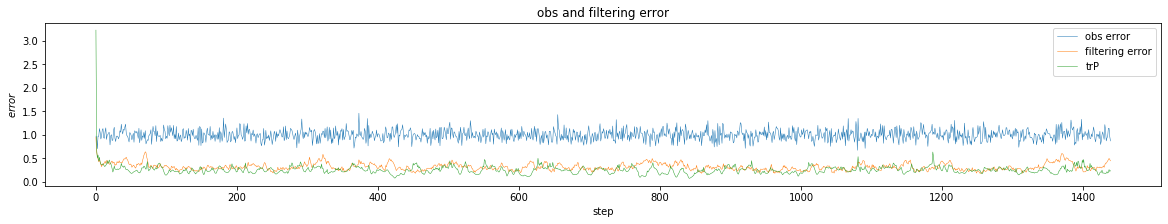

CPU times: user 32.6 s, sys: 72.9 ms, total: 32.6 s
Wall time: 32.7 s


(8, 0, 0.3110930737579182)

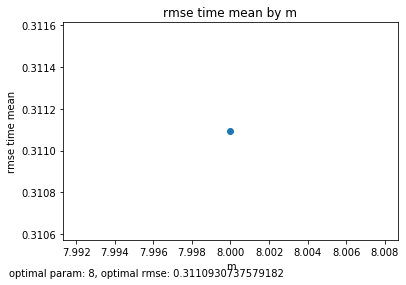

In [129]:
%%time
m = 8
alpha = 1.05
sigma = 2
letkf = SerialSRF(M, H, Q, R, y[:], x_0, P_0, m=m, alpha=alpha, c=sigma)
letkf.forward_estimation()
plot_error_KF(true, y, [letkf.x], trPs=[letkf.trP])
estimate_error_with_params(true, [letkf.x], [m], 'm')

In [125]:
%%time
m=8
spin_up = 150
duration = 150

num_alpha = 11
num_c = 10
params_alpha = np.linspace(1.0, 1.5, num=num_alpha)
params_c = np.arange(num_c) + 1
errors = np.zeros((num_alpha, num_c))

for i in range(num_alpha):
    alpha = params_alpha[i]
    for j in range(num_c):
        c = params_c[j]
        letkf = SerialSRF(M, H, Q, R, y[:spin_up+duration], x_0, P_0, m=m, alpha=alpha, c=c)
        letkf.forward_estimation()
        error = error_series_kf(true, letkf.x, time_index=np.arange(duration)+spin_up).mean()
        errors[i,j] = error
        print('complete: alpha: {}, c: {}, error: {}'.format(alpha, c, error))
    print('=======================')
df = pd.DataFrame(errors, index=params_alpha, columns=params_c)
# df.to_csv('data/letkf/letkf_alpha_c_rough.csv')

/Users/sakajokenkyusitutakeda/.pyenv/versions/anaconda3-2020.02/envs/startup/lib/python3.7/site-packages/ipykernel_launcher.py:97: ComplexWarning: Casting complex values to real discards the imaginary part


complete: alpha: 1.0, c: 1, error: 0.5137932271812454
complete: alpha: 1.0, c: 2, error: 0.3326693756651566
complete: alpha: 1.0, c: 3, error: 0.3315549703381354
complete: alpha: 1.0, c: 4, error: 0.3549204350526505
complete: alpha: 1.0, c: 5, error: 0.37394582602234333
complete: alpha: 1.0, c: 6, error: 0.3774552289610138
complete: alpha: 1.0, c: 7, error: 0.37732911085586535
complete: alpha: 1.0, c: 8, error: 0.37698250341983736
complete: alpha: 1.0, c: 9, error: 0.37676237046524846
complete: alpha: 1.0, c: 10, error: 0.3766416635892399
complete: alpha: 1.05, c: 1, error: 0.37123778273786895
complete: alpha: 1.05, c: 2, error: 0.30227466485487525
complete: alpha: 1.05, c: 3, error: 0.3088880135315474
complete: alpha: 1.05, c: 4, error: 0.30934987160167804
complete: alpha: 1.05, c: 5, error: 0.31011752755533906
complete: alpha: 1.05, c: 6, error: 0.3110870760181743
complete: alpha: 1.05, c: 7, error: 0.3120777150969939
complete: alpha: 1.05, c: 8, error: 0.31290117262453065
complete: 

Text(42.0, 0.5, 'alpha')

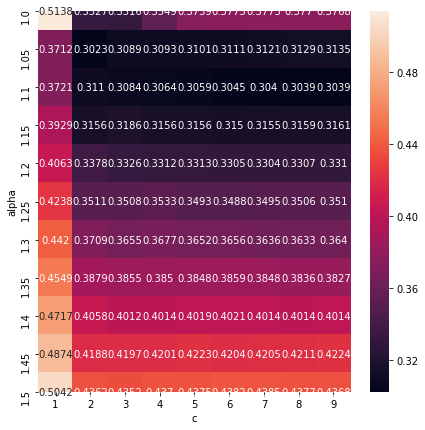

In [128]:
# df = pd.read_csv('data/letkf/letkf_alpha_c_rough.csv', index_col=0, header=0)
df = pd.DataFrame(errors, index=params_alpha, columns=params_c)

fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(df.iloc[:, :9], annot=True, fmt='.4g')
ax.set_xlabel('c')
ax.set_ylabel('alpha')